In [ ]:
for row_index in range(iteration[0]):
    for col_index in range(iteration[1]):
        con1 = (_row[row_index]<= data['y']) & (data['y']<=_row[row_index+1])
        con2 = (_col[col_index]<= data['x']) & (data['x']<=_col[col_index+1])
        df = data[con1 & con2]
        # df['row'] = df['row'] - 100 * row_index
        df['y'] = [_r - 100 * row_index for _r in df['y'].values]
        df['x'] = [_c - 100 * col_index for _c in df['x'].values]

        con1 = (_row[row_index]<= coordinates['y']) & (coordinates['y']<=_row[row_index+1])
        con2 = (_col[col_index]<= coordinates['x']) & (coordinates['x']<=_col[col_index+1])
        space = coordinates[con1 & con2]


        # 'row'와 'col' 열을 이용하여 튜플 리스트 생성
        required_pixels = [(x, y, z) for x, y, z in zip(df['x'], df['y'], df['z'])]

        # 데이터/파라미터 초기화
        N = 100  # 그리드의 가로 크기
        M = 100  # 그리드의 세로 크기
        J = range(N * M)  # 전체 그리드 픽셀 집합
        I = [y * N + x for (x, y, z) in required_pixels]
        Zj = [z for z in space['z']]
        Zi = [z for (x,y,z) in required_pixels]


        # 높이 고려 안했을 때의 최대 거리
        max_distance = r2

        # 제약 조건을 추가하기 전에, 각 i 픽셀에 대해 허용 가능한 j 픽셀만 필터링
        nearby_j = {i: [j for j in J if math.sqrt(((divmod(j, N)[0]-divmod(i, N)[0])**2 + 
                                                (divmod(j, N)[1]-divmod(i, N)[1])**2)) <= max_distance] for i in I}
        
        # 모델 생성
        model = gp.Model("pesticide_application")

        # 변수 생성
        S = model.addVars(J, vtype=GRB.BINARY, name="S")  # 살포 지점 j가 선택되었는지를 나타내는 이진 변수
        C = model.addVars([(i, j) for i in I for j in nearby_j[i]], vtype=GRB.BINARY, name="C")  # 지점 j에 의해서 지점 i가 커버될 수 있는지를 나타내는 이진 변수
        a = model.addVars(J, vtype=GRB.CONTINUOUS, name="a")

        # 목적 함수 설정: 최소한의 살포 지점 선택
        model.setObjective(gp.quicksum(S[j] for j in J), sense=GRB.MINIMIZE)

        # 제약 조건 추가
        index = 0
        for i in I:
            xi, yi = divmod(i, N)  # i 픽셀의 (x, y) 좌표
            zi = Zi[index]
            index += 1
            for j in nearby_j[i]:
                xj, yj = divmod(j, N)  # j 픽셀의 (x, y) 좌표
                zj = Zj[j]
                dist = math.sqrt(((xj-xi)**2 + (yj-yi)**2)) + t * (zi - zj)  # 두 좌표간의 거리

                # i 픽셀이 j 픽셀에 의해 커버될 수 있는지에 대한 제약 조건
                model.addConstr(dist * C[i,j]<=a[j])
                model.addConstr(r1 <= a[j])
                model.addConstr(a[j]<= r2)
                model.addConstr(S[j] >= C[i, j])

        # 모든 i가 적어도 하나의 j에 의해 커버되어야 한다는 제약 조건
        for i in I:
            model.addConstr(gp.quicksum(C[i, j] for j in nearby_j[i]) >= 1)

        # 모델 최적화
        model.optimize()


        # 두 번째 모델 생성
        second_model = gp.Model("second_model")

        # 첫 번째 모델의 변수와 제약 조건을 복사
        S2 = second_model.addVars(J, vtype=GRB.BINARY, name="S")
        C2 = second_model.addVars([(i, j) for i in I for j in nearby_j[i]], vtype=GRB.BINARY, name="C")
        a2 = second_model.addVars(J, vtype=GRB.CONTINUOUS, name="a")

        # 첫 번째 모델의 솔루션 고정
        if model.status == GRB.OPTIMAL:
            for j in J:
                S[j].start = S[j].x
                a[j].start = a[j].x
            for i, j in C.keys():
                C[i, j].start = C[i, j].x

            # 첫 번째 모델의 솔루션을 두 번째 모델에 고정
            for j in J:
                S2[j].lb = S[j].x
                S2[j].ub = S[j].x

            for i, j in C.keys():
                C2[i, j].lb = C[i, j].x
                C2[i, j].ub = C[i, j].x

        # 두 번째 모델의 목적 함수 설정
        second_model.setObjective(gp.quicksum(a2[j] for j in J), sense=GRB.MINIMIZE)

        # 제약 조건 추가
        index = 0
        for i in I:
            xi, yi = divmod(i, N)
            zi = Zi[index]
            index += 1
            for j in nearby_j[i]:
                xj, yj = divmod(j, N)
                zj = Zj[j]
                dist = math.sqrt((xj - xi)**2 + (yj - yi)**2) + t * (zi - zj)
                second_model.addConstr(r1 <= a2[j])
                second_model.addConstr(dist * C2[i, j] <= a2[j])
                second_model.addConstr(a2[j] <= r2)

        # 모든 i가 적어도 하나의 j에 의해 커버되어야 한다는 제약 조건
        for i in I:
            second_model.addConstr(gp.quicksum(C2[i, j] for j in nearby_j[i]) >= 1)

        # 두 번째 모델 최적화
        second_model.optimize()

In [1]:
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import random
import matplotlib.pyplot as plt
import math

# random 모듈 시드 설정
random.seed(42)

# 모델 생성
model = gp.Model("pesticide_application")

# 파일 읽기
file_path = 'weed_coordinates.txt'
data = pd.read_csv(file_path, sep=',')

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-01


In [21]:
con1 = data['row']<=100
con2 = data['col']<=100

df = data[con1 & con2]

In [2]:
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import random
import matplotlib.pyplot as plt
import math

# random 모듈 시드 설정
random.seed(42)

# 모델 생성
model = gp.Model("pesticide_application")

# 'row'와 'col' 열을 이용하여 튜플 리스트 생성
required_pixels = [(row, col) for row, col in zip(df['row'], df['col'])]

# 데이터/파라미터 초기화
N = 100  # 그리드의 가로 크기
M = 100  # 그리드의 세로 크기
J = range(N * M)  # 전체 그리드 픽셀 집합
I = [y * N + x for (x, y) in required_pixels] 

def calc_range():
    r = [57.73502691896256,
    115.47005383792512]

    return r[0]/10, r[-1]/10

r1, r2 = calc_range()

max_distance = r2  # 이 값은 적절하게 조정 가능

# 제약 조건을 추가하기 전에, 각 i 픽셀에 대해 허용 가능한 j 픽셀만 필터링
nearby_j = {i: [j for j in J if math.sqrt(((divmod(j, N)[0]-divmod(i, N)[0])**2 + 
                                           (divmod(j, N)[1]-divmod(i, N)[1])**2)) <= max_distance] for i in I}



NameError: name 'df' is not defined

In [23]:
# 변수 생성
S = model.addVars(J, vtype=GRB.BINARY, name="S")  # 살포 지점 j가 선택되었는지를 나타내는 이진 변수
C = model.addVars([(i, j) for i in I for j in nearby_j[i]], vtype=GRB.BINARY, name="C")  # 지점 j에 의해서 지점 i가 커버될 수 있는지를 나타내는 이진 변수
a = model.addVars(J, vtype=GRB.CONTINUOUS, name="a")

# 목적 함수 설정: 최소한의 살포 지점 선택
model.setObjective(gp.quicksum(S[j] for j in J), sense=GRB.MINIMIZE)

# 제약 조건 추가
for i in I:
    xi, yi = divmod(i, N)  # i 픽셀의 (x, y) 좌표
    for j in nearby_j[i]:
        xj, yj = divmod(j, N)  # j 픽셀의 (x, y) 좌표
        # zj = z_values[j]  # j 픽셀의 z 좌표
        dist = math.sqrt(((xj-xi)**2 + (yj-yi)**2)) # 두 좌표간의 거리

        # i 픽셀이 j 픽셀에 의해 커버될 수 있는지에 대한 제약 조건
        model.addConstr(dist * C[i,j]<=a[j])
        # model.addConstr(xj - aj <= xi + large_constant * (1 - C[i, j]))
        # model.addConstr(xi <= xj + aj + large_constant * (1 - C[i, j]))
        # model.addConstr(yj - aj <= yi + large_constant * (1 - C[i, j]))
        # model.addConstr(yi <= yj + aj + large_constant * (1 - C[i, j]))
        model.addConstr(r1 <= a[j])
        model.addConstr(a[j]<= r2)
        model.addConstr(S[j] >= C[i, j])

# 모든 i가 적어도 하나의 j에 의해 커버되어야 한다는 제약 조건
for i in I:
    model.addConstr(gp.quicksum(C[i, j] for j in nearby_j[i]) >= 1)

# 모델 최적화
model.optimize()

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i3-7020U CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 847112 rows, 231648 columns and 1481016 nonzeros
Model fingerprint: 0x66e29f17
Variable types: 10000 continuous, 221648 integer (221648 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 406.0000000
Presolve removed 656997 rows and 40000 columns (presolve time = 5s) ...
Presolve removed 846581 rows and 229584 columns (presolve time = 10s) ...
Presolve removed 847084 rows and 231611 columns
Presolve time: 11.40s
Presolved: 28 rows, 37 columns, 495 nonzeros
Found heuristic solution: objective 5.0000000
Variable types: 0 continuous, 37 integer (37 binary)

Root simplex log...

Iteration    Objective  

In [24]:
# 최적해 출력 및 시각화 준비
if model.status == GRB.OPTIMAL:
    solution = {v.varName: v.x for v in model.getVars() if v.x != 0}


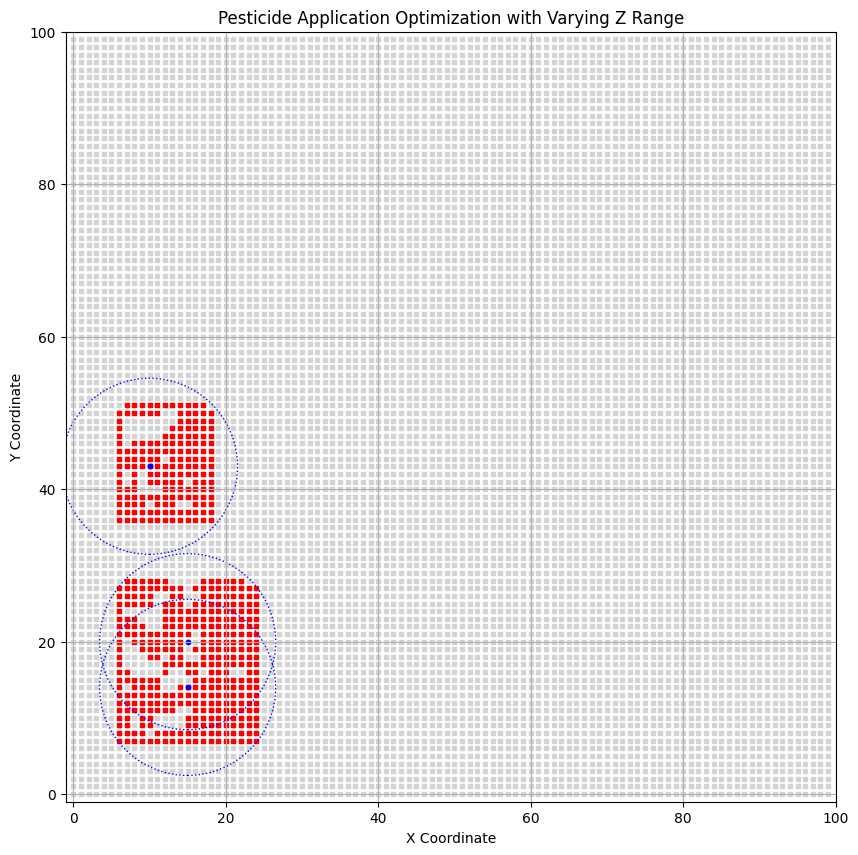

In [25]:
# 최적해 출력 및 시각화 준비
if model.status == GRB.OPTIMAL:
    # solution = {v.varName: v.x for v in model.getVars() if v.x != 0}

    # 시각화 코드
    fig, ax = plt.subplots(figsize=(12, 10))

    # 전체 그리드 픽셀
    for j in J:
        xj, yj = divmod(j, N)
        ax.scatter(xj, yj, color='lightgrey', marker='s', s=10)

    # 농약 살포가 필요한 픽셀
    for i in I:
        xi, yi = divmod(i, N)
        ax.scatter(xi, yi, color='red', marker='s', s=10)

    # 선택된 살포 지점 및 커버 범위
    for j in J:
        if S[j].x > 0.5:
            xj, yj = divmod(j, N)
            aj = a[j].x
            rect = plt.Circle((xj, yj), radius=aj, color='blue', fill=False, linestyle='dotted')
            ax.add_artist(rect)
            ax.scatter(xj, yj, color='blue', marker='o', s=10)

    plt.xlim(-1, N)
    plt.ylim(-1, M)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(True)
    plt.title('Pesticide Application Optimization with Varying Z Range')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.show()
else:
    print("No optimal solution found.")

In [86]:
con1 = (data['row']>100) & (data['row']<=200)
con2 = (data['col']<=100)

df = data[con1 & con2]
df['row'] = df['row'] - 100
df

C:\TempFolder\ipykernel_19068\2032723245.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['row'] = df['row'] - 100


,row,col
2318,54,10
2319,54,11
2320,54,12
2321,54,13
2322,54,14
...,...,...
3183,100,45
3184,100,46
3185,100,47
3186,100,50


In [87]:
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import random
import matplotlib.pyplot as plt
import math

# random 모듈 시드 설정
random.seed(42)

# 모델 생성
model = gp.Model("pesticide_application")

# 파일 읽기
# file_path = 'weed_coordinates.txt'
# data = pd.read_csv(file_path, sep=',')

# 'row'와 'col' 열을 이용하여 튜플 리스트 생성
required_pixels = [(row, col) for row, col in zip(df['row'], df['col'])]

# 데이터/파라미터 초기화
N = 100  # 그리드의 가로 크기
M = 100  # 그리드의 세로 크기
J = range(N * M)  # 전체 그리드 픽셀 집합
I = [N * y + x for (x, y) in required_pixels] 
large_constant = 10000000000  # 충분히 큰 상수
z_values = {j: random.randint(1, 3) for j in J}  # 각 픽셀의 z 좌표 (범위 제한: 1-3)

def calc_range():
    r = [57.73502691896256,
    63.508529610858815,
    69.28203230275507,
    75.05553499465132,
    80.8290376865476,
    86.60254037844385,
    92.3760430703401,
    98.14954576223636,
    103.92304845413261,
    109.69655114602887,
    115.47005383792512]

    return r[0]/10, r[-1]/10

r1, r2 = calc_range()

max_distance = 115.47005383792512/10  # 이 값은 적절하게 조정 가능

# 제약 조건을 추가하기 전에, 각 i 픽셀에 대해 허용 가능한 j 픽셀만 필터링
nearby_j = {i: [j for j in J if math.sqrt(((divmod(j, N)[0]-divmod(i, N)[0])**2 + 
                                           (divmod(j, N)[1]-divmod(i, N)[1])**2)) <= max_distance] for i in I}



In [88]:
# 변수 생성
S = model.addVars(J, vtype=GRB.BINARY, name="S")  # 살포 지점 j가 선택되었는지를 나타내는 이진 변수
C = model.addVars([(i, j) for i in I for j in nearby_j[i]], vtype=GRB.BINARY, name="C")  # 지점 j에 의해서 지점 i가 커버될 수 있는지를 나타내는 이진 변수
a = model.addVars(J, vtype=GRB.CONTINUOUS, name="a")

# 목적 함수 설정: 최소한의 살포 지점 선택
model.setObjective(gp.quicksum(S[j] for j in J), sense=GRB.MINIMIZE)

# 제약 조건 추가
for i in I:
    xi, yi = divmod(i, N)  # i 픽셀의 (x, y) 좌표
    for j in nearby_j[i]:
        xj, yj = divmod(j, N)  # j 픽셀의 (x, y) 좌표
        # zj = z_values[j]  # j 픽셀의 z 좌표
        dist = math.sqrt(((xj-xi)**2 + (yj-yi)**2)) # 두 좌표간의 거리

        # i 픽셀이 j 픽셀에 의해 커버될 수 있는지에 대한 제약 조건
        model.addConstr(dist * C[i,j]<=a[j])
        # model.addConstr(xj - aj <= xi + large_constant * (1 - C[i, j]))
        # model.addConstr(xi <= xj + aj + large_constant * (1 - C[i, j]))
        # model.addConstr(yj - aj <= yi + large_constant * (1 - C[i, j]))
        # model.addConstr(yi <= yj + aj + large_constant * (1 - C[i, j]))
        model.addConstr(r1 <= a[j])
        model.addConstr(a[j]<= r2)
        model.addConstr(S[j] >= C[i, j])

# 모든 i가 적어도 하나의 j에 의해 커버되어야 한다는 제약 조건
for i in I:
    model.addConstr(gp.quicksum(C[i, j] for j in nearby_j[i]) >= 1)

# 모델 최적화
model.optimize()

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i3-7020U CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 534561 rows, 153554 columns and 934543 nonzeros
Model fingerprint: 0x6be70f78
Variable types: 10000 continuous, 143554 integer (143554 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 294.0000000
Presolve removed 534250 rows and 151181 columns (presolve time = 5s) ...
Presolve removed 534561 rows and 153554 columns
Presolve time: 5.33s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 5.74 seconds (1.69 work units)
Thread count was 1 (of 4 available processors)

Solution count 2: 3 294 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.000000000000e+00

In [89]:
# 최적해 출력 및 시각화 준비
if model.status == GRB.OPTIMAL:
    solution = {v.varName: v.x for v in model.getVars() if v.x != 0}


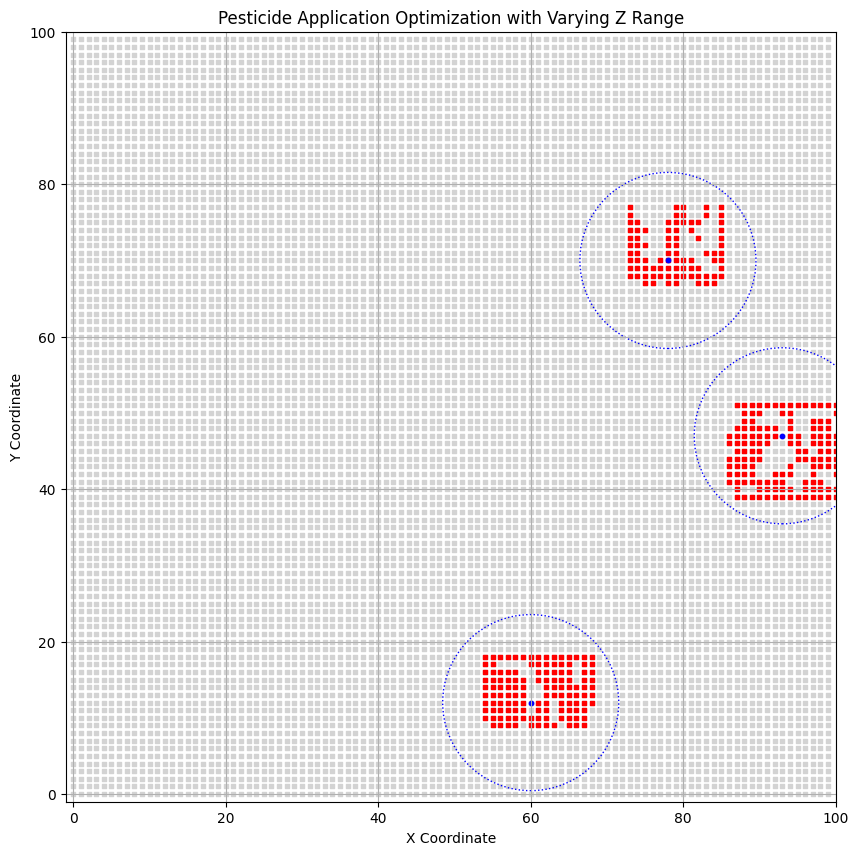

In [90]:
# 최적해 출력 및 시각화 준비
if model.status == GRB.OPTIMAL:
    # solution = {v.varName: v.x for v in model.getVars() if v.x != 0}

    # 시각화 코드
    fig, ax = plt.subplots(figsize=(12, 10))

    # 전체 그리드 픽셀
    for j in J:
        xj, yj = divmod(j, N)
        ax.scatter(xj, yj, color='lightgrey', marker='s', s=10)

    # 농약 살포가 필요한 픽셀
    for i in I:
        xi, yi = divmod(i, N)
        ax.scatter(xi, yi, color='red', marker='s', s=10)

    # 선택된 살포 지점 및 커버 범위
    for j in J:
        if S[j].x > 0.5:
            xj, yj = divmod(j, N)
            aj = a[j].x
            rect = plt.Circle((xj, yj), radius=aj, color='blue', fill=False, linestyle='dotted')
            ax.add_artist(rect)
            ax.scatter(xj, yj, color='blue', marker='o', s=10)

    plt.xlim(-1, N)
    plt.ylim(-1, M)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(True)
    plt.title('Pesticide Application Optimization with Varying Z Range')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.show()
else:
    print("No optimal solution found.")

In [49]:
con1 = (data['row']>200) & (data['row']<=300)
con2 = (data['col']<=100)

df = data[con1 & con2]
df['row'] = df['row'] - 200

In [50]:
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import random
import matplotlib.pyplot as plt
import math

# random 모듈 시드 설정
random.seed(42)

# 모델 생성
model = gp.Model("pesticide_application")

# 파일 읽기
# file_path = 'weed_coordinates.txt'
# data = pd.read_csv(file_path, sep=',')

# 'row'와 'col' 열을 이용하여 튜플 리스트 생성
required_pixels = [(row, col) for row, col in zip(df['row'], df['col'])]

# 데이터/파라미터 초기화
N = 100  # 그리드의 가로 크기
M = 100  # 그리드의 세로 크기
J = range(N * M)  # 전체 그리드 픽셀 집합
I = [y * N + x for (x, y) in required_pixels] 
large_constant = 10000000000  # 충분히 큰 상수
z_values = {j: random.randint(1, 3) for j in J}  # 각 픽셀의 z 좌표 (범위 제한: 1-3)

def calc_range():
    r = [57.73502691896256,
    63.508529610858815,
    69.28203230275507,
    75.05553499465132,
    80.8290376865476,
    86.60254037844385,
    92.3760430703401,
    98.14954576223636,
    103.92304845413261,
    109.69655114602887,
    115.47005383792512]

    return r[0]/10, r[-1]/10

r1, r2 = calc_range()

max_distance = 115.47005383792512/10  # 이 값은 적절하게 조정 가능

# 제약 조건을 추가하기 전에, 각 i 픽셀에 대해 허용 가능한 j 픽셀만 필터링
nearby_j = {i: [j for j in J if math.sqrt(((divmod(j, N)[0]-divmod(i, N)[0])**2 + 
                                           (divmod(j, N)[1]-divmod(i, N)[1])**2)) <= max_distance] for i in I}



In [51]:
# 변수 생성
S = model.addVars(J, vtype=GRB.BINARY, name="S")  # 살포 지점 j가 선택되었는지를 나타내는 이진 변수
C = model.addVars([(i, j) for i in I for j in nearby_j[i]], vtype=GRB.BINARY, name="C")  # 지점 j에 의해서 지점 i가 커버될 수 있는지를 나타내는 이진 변수
a = model.addVars(J, vtype=GRB.CONTINUOUS, name="a")

# 목적 함수 설정: 최소한의 살포 지점 선택
model.setObjective(gp.quicksum(S[j] for j in J), sense=GRB.MINIMIZE)

# 제약 조건 추가
for i in I:
    xi, yi = divmod(i, N)  # i 픽셀의 (x, y) 좌표
    for j in nearby_j[i]:
        xj, yj = divmod(j, N)  # j 픽셀의 (x, y) 좌표
        # zj = z_values[j]  # j 픽셀의 z 좌표
        dist = math.sqrt(((xj-xi)**2 + (yj-yi)**2)) # 두 좌표간의 거리

        # i 픽셀이 j 픽셀에 의해 커버될 수 있는지에 대한 제약 조건
        model.addConstr(dist * C[i,j]<=a[j])
        # model.addConstr(xj - aj <= xi + large_constant * (1 - C[i, j]))
        # model.addConstr(xi <= xj + aj + large_constant * (1 - C[i, j]))
        # model.addConstr(yj - aj <= yi + large_constant * (1 - C[i, j]))
        # model.addConstr(yi <= yj + aj + large_constant * (1 - C[i, j]))
        model.addConstr(r1 <= a[j])
        model.addConstr(a[j]<= r2)
        model.addConstr(S[j] >= C[i, j])

# 모든 i가 적어도 하나의 j에 의해 커버되어야 한다는 제약 조건
for i in I:
    model.addConstr(gp.quicksum(C[i, j] for j in nearby_j[i]) >= 1)

# 모델 최적화
model.optimize()

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i3-7020U CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 326415 rows, 101542 columns and 570547 nonzeros
Model fingerprint: 0x1f1cb260
Variable types: 10000 continuous, 91542 integer (91542 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 201.0000000
Presolve removed 326415 rows and 101542 columns
Presolve time: 3.16s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 3.40 seconds (0.99 work units)
Thread count was 1 (of 4 available processors)

Solution count 2: 3 201 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.000000000000e+00, best bound 3.000000000000e+00, gap 0.0000%


In [52]:
# 최적해 출력 및 시각화 준비
if model.status == GRB.OPTIMAL:
    solution = {v.varName: v.x for v in model.getVars() if v.x != 0}


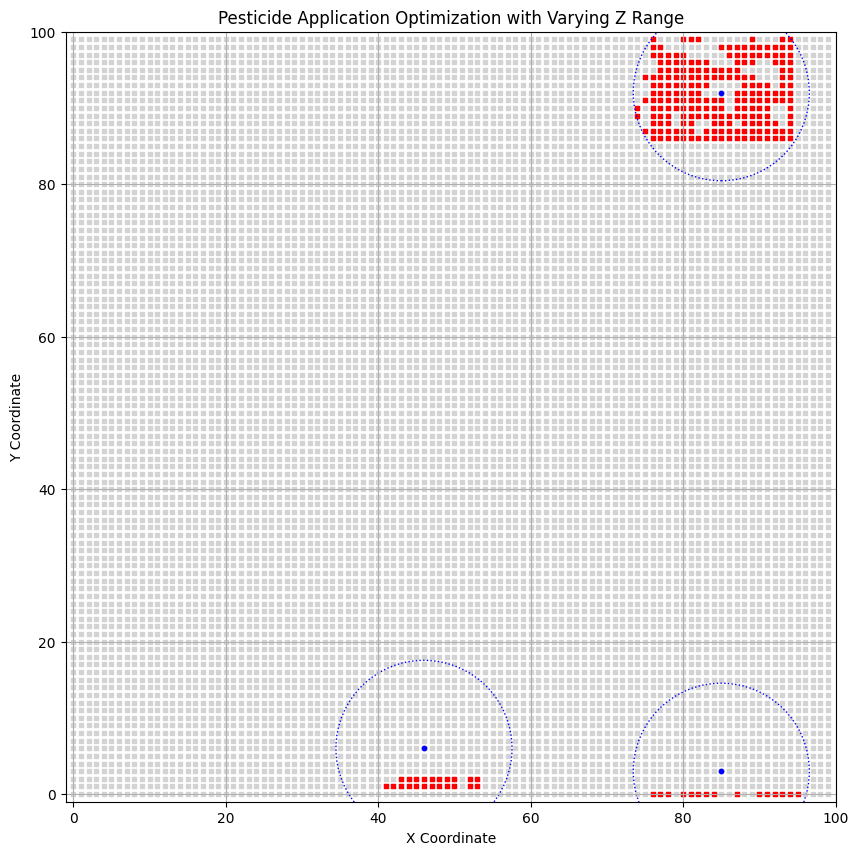

In [53]:
# 최적해 출력 및 시각화 준비
if model.status == GRB.OPTIMAL:
    # solution = {v.varName: v.x for v in model.getVars() if v.x != 0}

    # 시각화 코드
    fig, ax = plt.subplots(figsize=(12, 10))

    # 전체 그리드 픽셀
    for j in J:
        xj, yj = divmod(j, N)
        ax.scatter(xj, yj, color='lightgrey', marker='s', s=10)

    # 농약 살포가 필요한 픽셀
    for i in I:
        xi, yi = divmod(i, N)
        ax.scatter(xi, yi, color='red', marker='s', s=10)

    # 선택된 살포 지점 및 커버 범위
    for j in J:
        if S[j].x > 0.5:
            xj, yj = divmod(j, N)
            aj = a[j].x
            rect = plt.Circle((xj, yj), radius=aj, color='blue', fill=False, linestyle='dotted')
            ax.add_artist(rect)
            ax.scatter(xj, yj, color='blue', marker='o', s=10)

    plt.xlim(-1, N)
    plt.ylim(-1, M)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(True)
    plt.title('Pesticide Application Optimization with Varying Z Range')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.show()
else:
    print("No optimal solution found.")

In [54]:
con1 = (data['row']>300) & (data['row']<=400)
con2 = (data['col']<=100)

df = data[con1 & con2]
df['row'] = df['row'] - 300

In [55]:
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import random
import matplotlib.pyplot as plt
import math

# random 모듈 시드 설정
random.seed(42)

# 모델 생성
model = gp.Model("pesticide_application")

# 파일 읽기
# file_path = 'weed_coordinates.txt'
# data = pd.read_csv(file_path, sep=',')

# 'row'와 'col' 열을 이용하여 튜플 리스트 생성
required_pixels = [(row, col) for row, col in zip(df['row'], df['col'])]

# 데이터/파라미터 초기화
N = 100  # 그리드의 가로 크기
M = 100  # 그리드의 세로 크기
J = range(N * M)  # 전체 그리드 픽셀 집합
I = [y * N + x for (x, y) in required_pixels] 
large_constant = 10000000000  # 충분히 큰 상수
z_values = {j: random.randint(1, 3) for j in J}  # 각 픽셀의 z 좌표 (범위 제한: 1-3)

def calc_range():
    r = [57.73502691896256,
    63.508529610858815,
    69.28203230275507,
    75.05553499465132,
    80.8290376865476,
    86.60254037844385,
    92.3760430703401,
    98.14954576223636,
    103.92304845413261,
    109.69655114602887,
    115.47005383792512]

    return r[0]/10, r[-1]/10

r1, r2 = calc_range()

max_distance = 115.47005383792512/10  # 이 값은 적절하게 조정 가능

# 제약 조건을 추가하기 전에, 각 i 픽셀에 대해 허용 가능한 j 픽셀만 필터링
nearby_j = {i: [j for j in J if math.sqrt(((divmod(j, N)[0]-divmod(i, N)[0])**2 + 
                                           (divmod(j, N)[1]-divmod(i, N)[1])**2)) <= max_distance] for i in I}



In [56]:
# 변수 생성
S = model.addVars(J, vtype=GRB.BINARY, name="S")  # 살포 지점 j가 선택되었는지를 나타내는 이진 변수
C = model.addVars([(i, j) for i in I for j in nearby_j[i]], vtype=GRB.BINARY, name="C")  # 지점 j에 의해서 지점 i가 커버될 수 있는지를 나타내는 이진 변수
a = model.addVars(J, vtype=GRB.CONTINUOUS, name="a")

# 목적 함수 설정: 최소한의 살포 지점 선택
model.setObjective(gp.quicksum(S[j] for j in J), sense=GRB.MINIMIZE)

# 제약 조건 추가
for i in I:
    xi, yi = divmod(i, N)  # i 픽셀의 (x, y) 좌표
    for j in nearby_j[i]:
        xj, yj = divmod(j, N)  # j 픽셀의 (x, y) 좌표
        # zj = z_values[j]  # j 픽셀의 z 좌표
        dist = math.sqrt(((xj-xi)**2 + (yj-yi)**2)) # 두 좌표간의 거리

        # i 픽셀이 j 픽셀에 의해 커버될 수 있는지에 대한 제약 조건
        model.addConstr(dist * C[i,j]<=a[j])
        # model.addConstr(xj - aj <= xi + large_constant * (1 - C[i, j]))
        # model.addConstr(xi <= xj + aj + large_constant * (1 - C[i, j]))
        # model.addConstr(yj - aj <= yi + large_constant * (1 - C[i, j]))
        # model.addConstr(yi <= yj + aj + large_constant * (1 - C[i, j]))
        model.addConstr(r1 <= a[j])
        model.addConstr(a[j]<= r2)
        model.addConstr(S[j] >= C[i, j])

# 모든 i가 적어도 하나의 j에 의해 커버되어야 한다는 제약 조건
for i in I:
    model.addConstr(gp.quicksum(C[i, j] for j in nearby_j[i]) >= 1)

# 모델 최적화
model.optimize()

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i3-7020U CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 200737 rows, 70142 columns and 350840 nonzeros
Model fingerprint: 0xf2b5d84e
Variable types: 10000 continuous, 60142 integer (60142 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 143.0000000
Presolve removed 200737 rows and 70142 columns
Presolve time: 1.46s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 1.62 seconds (0.51 work units)
Thread count was 1 (of 4 available processors)

Solution count 2: 2 143 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.000000000000e+00, best bound 2.000000000000e+00, gap 0.0000%


In [57]:
# 최적해 출력 및 시각화 준비
if model.status == GRB.OPTIMAL:
    solution = {v.varName: v.x for v in model.getVars() if v.x != 0}


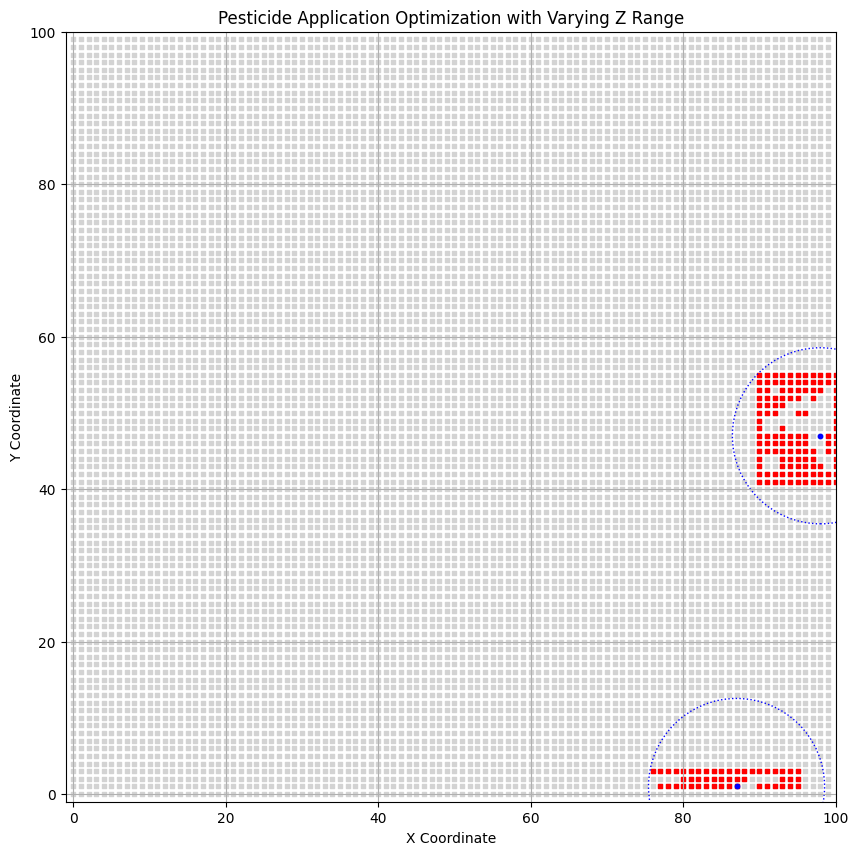

In [58]:
# 최적해 출력 및 시각화 준비
if model.status == GRB.OPTIMAL:
    # solution = {v.varName: v.x for v in model.getVars() if v.x != 0}

    # 시각화 코드
    fig, ax = plt.subplots(figsize=(12, 10))

    # 전체 그리드 픽셀
    for j in J:
        xj, yj = divmod(j, N)
        ax.scatter(xj, yj, color='lightgrey', marker='s', s=10)

    # 농약 살포가 필요한 픽셀
    for i in I:
        xi, yi = divmod(i, N)
        ax.scatter(xi, yi, color='red', marker='s', s=10)

    # 선택된 살포 지점 및 커버 범위
    for j in J:
        if S[j].x > 0.5:
            xj, yj = divmod(j, N)
            aj = a[j].x
            rect = plt.Circle((xj, yj), radius=aj, color='blue', fill=False, linestyle='dotted')
            ax.add_artist(rect)
            ax.scatter(xj, yj, color='blue', marker='o', s=10)

    plt.xlim(-1, N)
    plt.ylim(-1, M)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(True)
    plt.title('Pesticide Application Optimization with Varying Z Range')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.show()
else:
    print("No optimal solution found.")

In [59]:
con1 = (data['row']>400) & (data['row']<=512)
con2 = (data['col']<=100)

df = data[con1 & con2]
df['row'] = df['row'] - 400

In [60]:
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import random
import matplotlib.pyplot as plt
import math

# random 모듈 시드 설정
random.seed(42)

# 모델 생성
model = gp.Model("pesticide_application")

# 파일 읽기
# file_path = 'weed_coordinates.txt'
# data = pd.read_csv(file_path, sep=',')

# 'row'와 'col' 열을 이용하여 튜플 리스트 생성
required_pixels = [(row, col) for row, col in zip(df['row'], df['col'])]

# 데이터/파라미터 초기화
N = 100  # 그리드의 가로 크기
M = 100  # 그리드의 세로 크기
J = range(N * M)  # 전체 그리드 픽셀 집합
I = [y * N + x for (x, y) in required_pixels] 
large_constant = 10000000000  # 충분히 큰 상수
z_values = {j: random.randint(1, 3) for j in J}  # 각 픽셀의 z 좌표 (범위 제한: 1-3)

def calc_range():
    r = [57.73502691896256,
    63.508529610858815,
    69.28203230275507,
    75.05553499465132,
    80.8290376865476,
    86.60254037844385,
    92.3760430703401,
    98.14954576223636,
    103.92304845413261,
    109.69655114602887,
    115.47005383792512]

    return r[0]/10, r[-1]/10

r1, r2 = calc_range()

max_distance = 115.47005383792512/10  # 이 값은 적절하게 조정 가능

# 제약 조건을 추가하기 전에, 각 i 픽셀에 대해 허용 가능한 j 픽셀만 필터링
nearby_j = {i: [j for j in J if math.sqrt(((divmod(j, N)[0]-divmod(i, N)[0])**2 + 
                                           (divmod(j, N)[1]-divmod(i, N)[1])**2)) <= max_distance] for i in I}



In [61]:
# 변수 생성
S = model.addVars(J, vtype=GRB.BINARY, name="S")  # 살포 지점 j가 선택되었는지를 나타내는 이진 변수
C = model.addVars([(i, j) for i in I for j in nearby_j[i]], vtype=GRB.BINARY, name="C")  # 지점 j에 의해서 지점 i가 커버될 수 있는지를 나타내는 이진 변수
a = model.addVars(J, vtype=GRB.CONTINUOUS, name="a")

# 목적 함수 설정: 최소한의 살포 지점 선택
model.setObjective(gp.quicksum(S[j] for j in J), sense=GRB.MINIMIZE)

# 제약 조건 추가
for i in I:
    xi, yi = divmod(i, N)  # i 픽셀의 (x, y) 좌표
    for j in nearby_j[i]:
        xj, yj = divmod(j, N)  # j 픽셀의 (x, y) 좌표
        # zj = z_values[j]  # j 픽셀의 z 좌표
        dist = math.sqrt(((xj-xi)**2 + (yj-yi)**2)) # 두 좌표간의 거리

        # i 픽셀이 j 픽셀에 의해 커버될 수 있는지에 대한 제약 조건
        model.addConstr(dist * C[i,j]<=a[j])
        # model.addConstr(xj - aj <= xi + large_constant * (1 - C[i, j]))
        # model.addConstr(xi <= xj + aj + large_constant * (1 - C[i, j]))
        # model.addConstr(yj - aj <= yi + large_constant * (1 - C[i, j]))
        # model.addConstr(yi <= yj + aj + large_constant * (1 - C[i, j]))
        model.addConstr(r1 <= a[j])
        model.addConstr(a[j]<= r2)
        model.addConstr(S[j] >= C[i, j])

# 모든 i가 적어도 하나의 j에 의해 커버되어야 한다는 제약 조건
for i in I:
    model.addConstr(gp.quicksum(C[i, j] for j in nearby_j[i]) >= 1)

# 모델 최적화
model.optimize()

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i3-7020U CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 298669 rows, 94622 columns and 522173 nonzeros
Model fingerprint: 0xf4025973
Variable types: 10000 continuous, 84622 integer (84622 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 146.0000000
Presolve removed 298659 rows and 94612 columns
Presolve time: 3.50s
Presolved: 10 rows, 10 columns, 52 nonzeros
Found heuristic solution: objective 2.0000000
Variable types: 0 continuous, 10 integer (10 binary)

Root relaxation: cutoff, 3 iterations, 0.02 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestB

In [62]:
# 최적해 출력 및 시각화 준비
if model.status == GRB.OPTIMAL:
    solution = {v.varName: v.x for v in model.getVars() if v.x != 0}


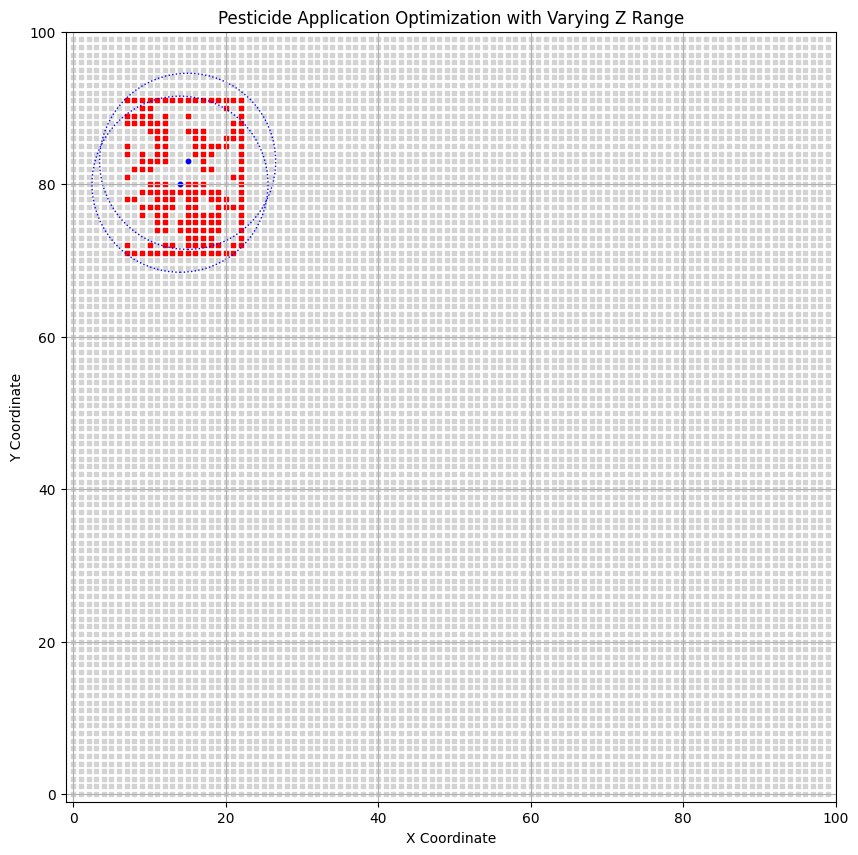

In [63]:
# 최적해 출력 및 시각화 준비
if model.status == GRB.OPTIMAL:
    # solution = {v.varName: v.x for v in model.getVars() if v.x != 0}

    # 시각화 코드
    fig, ax = plt.subplots(figsize=(12, 10))

    # 전체 그리드 픽셀
    for j in J:
        xj, yj = divmod(j, N)
        ax.scatter(xj, yj, color='lightgrey', marker='s', s=10)

    # 농약 살포가 필요한 픽셀
    for i in I:
        xi, yi = divmod(i, N)
        ax.scatter(xi, yi, color='red', marker='s', s=10)

    # 선택된 살포 지점 및 커버 범위
    for j in J:
        if S[j].x > 0.5:
            xj, yj = divmod(j, N)
            aj = a[j].x
            rect = plt.Circle((xj, yj), radius=aj, color='blue', fill=False, linestyle='dotted')
            ax.add_artist(rect)
            ax.scatter(xj, yj, color='blue', marker='o', s=10)

    plt.xlim(-1, N)
    plt.ylim(-1, M)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(True)
    plt.title('Pesticide Application Optimization with Varying Z Range')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.show()
else:
    print("No optimal solution found.")